In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn, spherical_yn , hankel1,lpmv,jn
import cmath
import matplotlib.gridspec as gridspec

In [2]:
def MieCoef(x, M, n):
    # Computing spherical Bessel functions for n and M*n
    j_n_x = spherical_jn(n, x)
    j_n_Mx = spherical_jn(n, M*x)

    # Computing Riccati-Bessel functions
    psi_n_x = x * j_n_x
    zeta_n_x = x * cmath.sqrt(np.pi/(2*x))*hankel1(n+1/2,x)

    psi_n_Mx = M * x * j_n_Mx
    zeta_n_Mx = M * x * cmath.sqrt(np.pi/(2*M*x))*hankel1(n+1/2,M*x)

    # Computing Riccati-Bessel function derivatives using numdifftools
    #psi_n_x_prime = nd.Derivative(lambda x: x * spherical_jn(n, x), n=1, order=1)(x)
    psi_n_x_prime = 1/2* (  x* (spherical_jn(n-1,x)-spherical_jn(n+1,x)) + spherical_jn(n,x) ) 
    
    zeta_n_x_prime = 1/2* cmath.sqrt(np.pi/(2*x))*(  x* (hankel1(n+1/2-1,x)-hankel1(n+1/2+1,x)) + hankel1(n+1/2,x) )

    #psi_n_Mx_prime = nd.Derivative(lambda x: M * x * spherical_jn(n, M * x), n=1, order=1)(x)
    psi_n_Mx_prime = 1/2* (  M*x* (spherical_jn(n-1,M*x)-spherical_jn(n+1,M*x)) + spherical_jn(n,M*x) ) 
    
    zeta_n_Mx_prime= 1/2* cmath.sqrt(np.pi/(2*M*x))*(  x* (hankel1(n+1/2-1,M*x)-hankel1(n+1/2+1,M*x)) + hankel1(n+1/2,M*x) )

    # Calculating coefficients a_n, b_n, c_n, d_n
    a_n = (M * psi_n_Mx * psi_n_x_prime - psi_n_Mx_prime * psi_n_x) / (psi_n_Mx_prime * zeta_n_x - M * psi_n_Mx * zeta_n_x_prime)
    b_n = (M * psi_n_Mx_prime * psi_n_x - psi_n_Mx * psi_n_x_prime) / (psi_n_Mx * zeta_n_x_prime - M * psi_n_Mx_prime * zeta_n_x)
    
    #c_n = (psi_n_x * zeta_n_x_prime - psi_n_x_prime * zeta_n_x) / (psi_n_Mx_prime * zeta_n_x - M * psi_n_Mx * zeta_n_x_prime)
    #d_n = (psi_n_x_prime * zeta_n_x - psi_n_x * zeta_n_x_prime) / (psi_n_Mx * zeta_n_x_prime - M * psi_n_Mx_prime * zeta_n_x)

    return a_n, b_n

def MieCoefCond2(x, n, k1):
    jn = spherical_jn(n, x)
    jn1 = spherical_jn(n+1,x)
    jn_1 = spherical_jn(n-1,x)
    
    hankeln = np.sqrt(np.pi/(2*x))*hankel1(n+1/2,x)
    hankeln1 = np.sqrt(np.pi/(2*x))*hankel1(n+1+1/2,x)
    hankeln_1 = np.sqrt(np.pi/(2*x))*hankel1(n-1+1/2,x)
    
    a = -(jn + x *1/2* (  x* (jn_1-jn1) + jn ))/(hankeln + x  *1/2* ( x*(hankeln_1-hankeln1) + hankeln))

    b = - jn/hankeln  

    
    return a, b


def E1_SCATnm(n, a_n, b_n, k, x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.sign(y) * np.arccos(x/np.sqrt(x**2+y**2))
    theta = np.arccos(z / r)

    kr = k * r
    hn = np.sqrt(np.pi / (2 * kr)) * hankel1(n + 1 / 2, kr)
    hn1 = np.sqrt(np.pi / (2 * kr)) * hankel1(n + 1 / 2 + 1, kr)
    Pn1 = lpmv(1, n + 1, np.cos(theta))
    Pn = lpmv(1, n, np.cos(theta))

    dP = (n * Pn1 - (n + 1) * np.cos(theta) * Pn) / np.sin(theta)
    P = Pn / np.sin(theta)

    # Replace zero values of dP and P at theta=0 with -1/2*n*(n+1)

    zero_theta_indices = (np.where(abs(theta) < 10**(-10))[0])
    dP[zero_theta_indices] = -0.5 * n * (n + 1)
    P[zero_theta_indices] = -0.5 * n * (n + 1)

    zero_theta_indices = (np.isnan(phi))
    phi[zero_theta_indices] = 0
    
    Gn = 1j**n
    prefac = -Gn / (n * (n + 1)) * (2 * n + 1) * 1j

    term_r = -a_n / kr * hn * Pn * n * (n + 1) * np.cos(phi)
    term_the = (-a_n / kr * ((n + 1) * hn - kr * hn1) * dP - 1j * b_n * hn * P) * np.cos(phi)
    term_phi = (a_n / kr * ((n + 1) * hn - kr * hn1) * P + 1j * b_n * hn * dP) * np.sin(phi)

    return prefac * (np.array([term_r * np.cos(phi) * np.sin(theta), term_r * np.sin(theta) * np.sin(phi), term_r * np.cos(theta)]) +
                     np.array([term_the * np.cos(phi) * np.cos(theta), term_the * np.cos(theta) * np.sin(phi), -term_the * np.sin(theta)]) +
                     np.array([-term_phi * np.sin(phi), term_phi * np.cos(phi), np.zeros_like(r)]))


In [10]:
R1= 100#1*u.mm

lamb = 0.632#633*u.nm
z= np.array([1e3,2*1e3,3*1e3,4*1e3,5*1e3,6*1e3,7*1e3,8*1e3,9*1e3,1e4,2*1e4,3*1e4,4*1e4])/10#100*u.mm
N=100

In [11]:
# Constants
N0 = 200000
k = 2 * np.pi / lamb
x_value = k * R1
M = 1.482#1 / 1.4482

y=0
#np.linspace(-80,80,301)

x_=[]
E_=[]
U = []
for j in range(len(z)):
    x = np.linspace(-0.2*R1,0.2*R1,N,endpoint=False)
    x_.append(x)
    E01_sca = 0
    for i in range(1,N0):
        a_n,b_n = MieCoefCond2(x_value, i, k)
        #a_n,b_n = MieCoef(x_value,M, i)
        if np.isnan(np.abs(a_n)) or np.isnan(np.abs(b_n)) :
            print('Limit Achived')
            break
            # Calculate the scattered electric field for both m=1 and m=-1
        E01_sca += E1_SCATnm(i, a_n, b_n, k, x, y,z[j])
    E_.append(E01_sca)
    zi = z[j]-R1
    U.append(zi**2/(zi**2+R1**2) * jn(0,2*R1*np.pi/lamb*x/zi)**2)


C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\1999587758.py:52: RuntimeWarning: invalid value encountered in divide
  phi = np.sign(y) * np.arccos(x/np.sqrt(x**2+y**2))
C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\1999587758.py:61: RuntimeWarning: invalid value encountered in divide
  dP = (n * Pn1 - (n + 1) * np.cos(theta) * Pn) / np.sin(theta)
C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\1999587758.py:62: RuntimeWarning: invalid value encountered in divide
  P = Pn / np.sin(theta)
C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\1999587758.py:42: RuntimeWarning: invalid value encountered in scalar divide
  a = -(jn + x *1/2* (  x* (jn_1-jn1) + jn ))/(hankeln + x  *1/2* ( x*(hankeln_1-hankeln1) + hankeln))
C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\3354397974.py:27: RuntimeWarning: divide by zero encountered in divide
  U.append(zi**2/(zi**2+R1**2) * jn(0,2*R1*np.pi/lamb*x/zi)**2)
C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\3354397974.py:27: RuntimeWarning:

Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived
Limit Achived


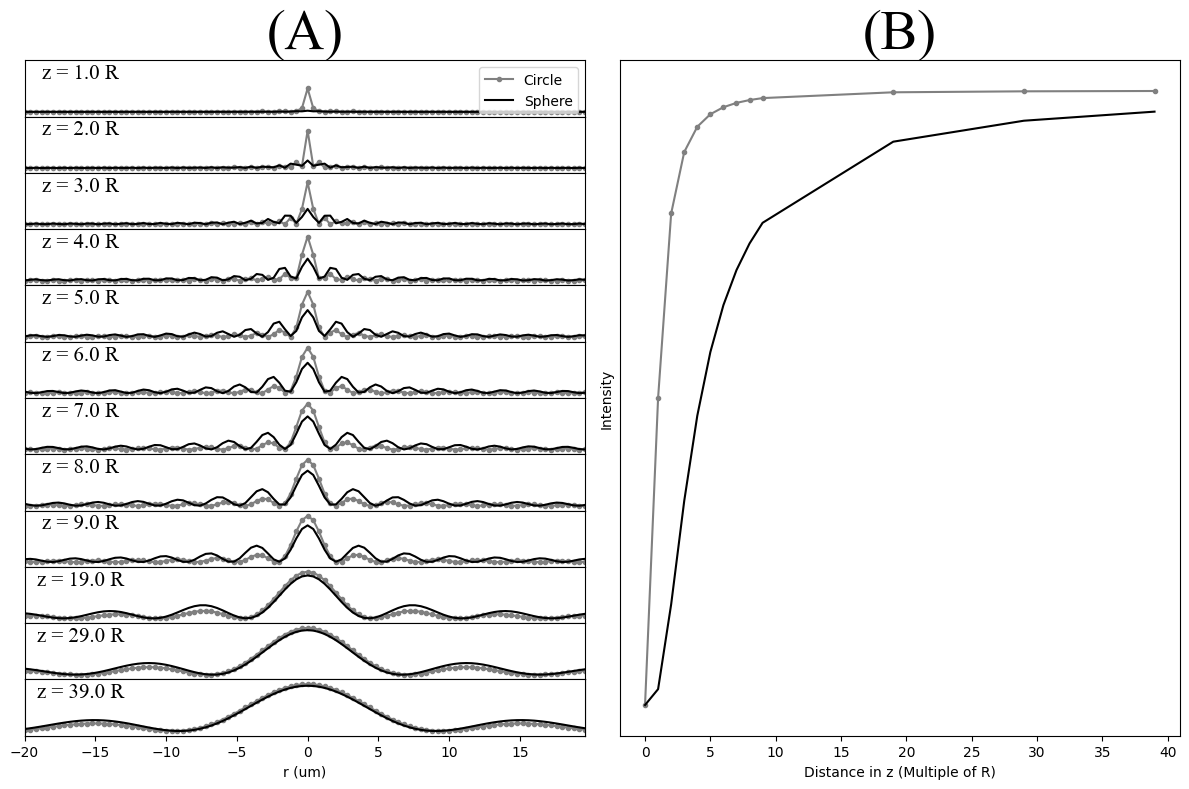

In [12]:
import matplotlib.gridspec as gridspec

# Create the figure and grid specification
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(len(z)-1,2, hspace=0.0)  # Adjust `wspace` to control space between columns
UU = []
# Create subplots in the first column
for u in range(len(z)):
    ax1 = fig.add_subplot(gs[u-1, 0])

    # Plot Fourier Optics data
    UU15 = U[u]
    if u>0:
        ax1.plot(x_[u], UU15, '.-',color='gray', label='Circle')

    # Compute electric field and plot Mie Scattering data
    E_inc = np.array([np.ones(len(x_[u])) * np.exp(1j * k * z[u]), np.zeros(len(x_[u])), np.zeros(len(x_[u]))])
    EE = E_inc + E_[u]
    UM = abs(EE[0])**2 + np.abs(EE[1])**2 + np.abs(EE[2])**2
    UU.append(UM)
    if u>0:
        ax1.plot(x_[u], UM, '-',color='black' ,label='Sphere')

    ax1.set_xlim(x_[0][0], x_[0][-1])  # Ensure consistent x-axis limits
    ax1.set_ylim(-0.1,1.1)
    #ax1.set_ylabel('Intensity')
    ax1.set_yticks([])

    ax1.annotate(f'z = {round((z[u]-R1)//R1,1)} R', xy=(0.5, 0.95), xycoords='axes fraction',
                 xytext=(0.1, 0.95), textcoords='axes fraction',
                 ha='center', va='top', fontname='Times New Roman', fontsize=15)
    if u == 1:
        ax1.legend(loc ='upper right' )  # Display legend in the first subplot
        ax1.set_title('(A)',fontname='Times New Roman',fontsize=40)
    if u < len(z)-1:
        ax1.set_xticks([])
        ax1.xaxis.set_visible(False)
        ax1.xaxis.set_ticks_position('none')
        

# Make all x-axes share the same properties
plt.setp([fig.axes[i] for i in range(len(z))], xlabel='r (um)')  # Align x-axis labels

# Create subplot in the second column
ax2 = fig.add_subplot(gs[:, 1])

zi = (z-R1)
ax2.plot(zi//R1, zi**2/(zi**2+R1**2), '.-', color='gray',label=f'Circle')
ax2.plot(zi//R1, np.transpose(UU)[N//2], '-', color='black', label='Sphere')

ax2.set_ylabel('Intensity')
ax2.set_yticks([])
ax2.set_xlabel('Distance in z (Multiple of R)')
ax2.set_title('(B)',fontname='Times New Roman',fontsize=40)

plt.tight_layout()  # Adjusts spacing to prevent overlap
plt.savefig('Comparar.svg',dpi=300)  # Display the plot

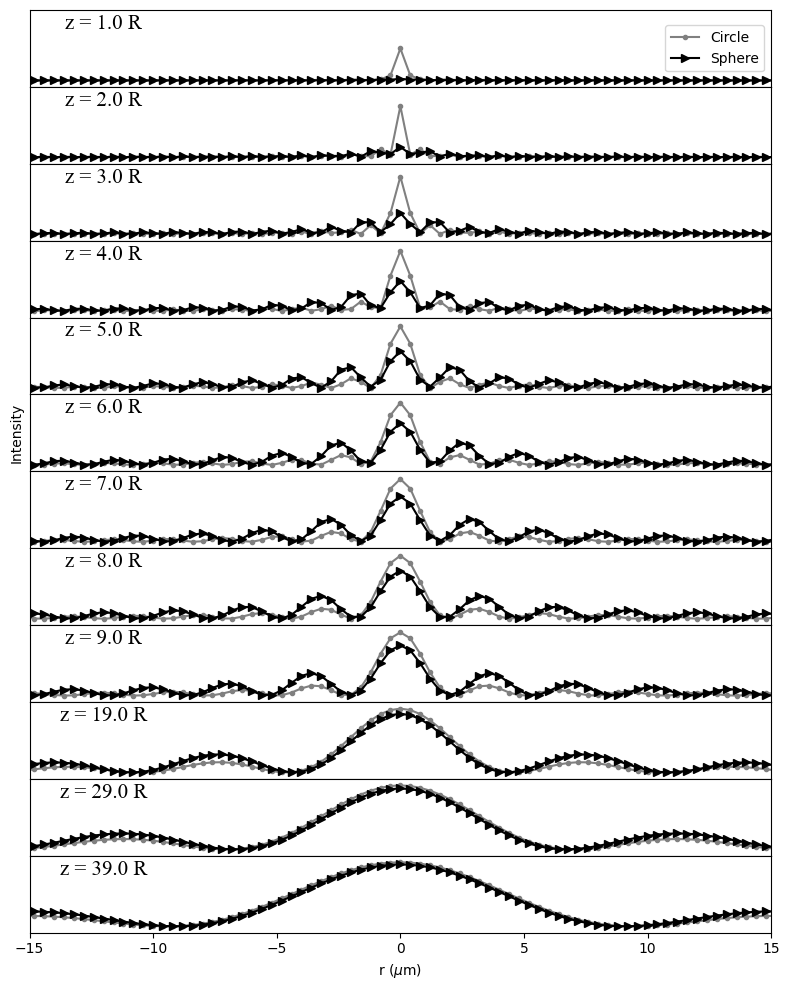

In [13]:
# Create the figure and grid specification
fig = plt.figure(figsize=(8, 10))
gs = gridspec.GridSpec(len(z)-1,1, hspace=0.0)  # Adjust `wspace` to control space between columns
UU = [np.ones(N)*0]
# Create subplots in the first column
for u in range(1,len(z)):
    ax1 = fig.add_subplot(gs[u-1, 0])

    # Plot Fourier Optics data
    UU15 = U[u]
    
    ax1.plot(x_[u], UU15, '.-',color='gray', label='Circle')

    # Compute electric field and plot Mie Scattering data
    E_inc = np.array([np.ones(len(x_[u])) * np.exp(1j * k * z[u]), np.zeros(len(x_[u])), np.zeros(len(x_[u]))])
    EE = E_inc + E_[u]
    UM = abs(EE[0])**2 + np.abs(EE[1])**2 + np.abs(EE[2])**2
    UU.append(UM)
    
    ax1.plot(x_[u], UM, '>-',color='black' ,label='Sphere')

    ax1.set_xlim(-15, 15)  # Ensure consistent x-axis limits
    ax1.set_ylim(-0.1,1.1)
    #ax1.set_ylabel('Intensity')
    ax1.set_yticks([])
    
    ax1.annotate(f'z = {round((z[u]-R1)//R1,1)} R', xy=(0.5, 0.95), xycoords='axes fraction',
                 xytext=(0.1, 0.95), textcoords='axes fraction',
                 ha='center', va='top', fontname='Times New Roman', fontsize=15)
    if u == 1:
        ax1.legend(loc ='center right' )  # Display legend in the first subplot
        #ax1.set_title('(A)',fontname='Times New Roman',fontsize=40)
    if u < len(z)-1:
        ax1.set_xticks([])
        ax1.xaxis.set_visible(False)
        ax1.xaxis.set_ticks_position('none')
        


# Make all x-axes share the same properties
plt.setp([fig.axes[i] for i in range(len(z)-1)], xlabel=r'r ($\mu$m)')  # Align x-axis labels
plt.setp(fig.axes[len(z)//2-1], ylabel=r'Intensity')  # Align x-axis labels
plt.tight_layout()  # Adjusts spacing to prevent overlap
#plt.savefig('Comparar1.pdf',dpi=300)  # Display the plot



**Looking at the Z axis**

In [14]:
def EZ0_SCATnm(n, a_n, b_n, k, x, y, z):
    r = np.sqrt(x**2+y**2+z**2)
    phi = np.pi/2
    theta = 0
    kr = k*r

    hn = np.sqrt(np.pi/(2*kr))*hankel1(n+1/2,kr)
    hn1 = np.sqrt(np.pi/(2*kr))*hankel1(n+1/2+1,kr)

    Gn = 1j**(n) 
    prefac = Gn/2 *(2*n+1)*1j

    term_the = (-a_n/kr* ( (n+1)*hn - kr*hn1 ) -1j* b_n * hn )*np.cos(phi)
    
    term_phi = (a_n/kr* ( (n+1)*hn - kr*hn1 ) +1j* b_n * hn)* np.sin(phi)
    
    term_r = np.zeros_like(term_the) 

    return prefac* ( np.array([term_r*np.cos(phi)*np.sin(theta),term_r*np.sin(theta)*np.sin(phi),term_r*np.cos(theta)]) + 
     np.array([term_the*np.cos(phi)*np.cos(theta) ,term_the*np.cos(theta)*np.sin(phi), - term_the*np.sin(theta)]) + 
     np.array([-term_phi *np.sin(phi) , term_phi*np.cos(phi) , term_phi *0 ]) )


In [17]:
N0= int(3*10**4)#11000
R = [50,100,200,1000]
M = 1.48
lamb=0.632
x = 0
y = 0

EE_=[]
zz_=[]
for j in R:
    E3_sca=0
    k = 2*np.pi/lamb
    x_value = k * j

    part1 = np.linspace(j, 7*j, 20)
    part2 = np.linspace(7*j, 60*j, 40)

    z3 = np.concatenate((part1, part2)) #np.linspace(j,30*j,30)
    for i in range(1,N0):    
        a_nm,b_nm = MieCoefCond2(x_value, i, k)
        #a_nm,b_nm = MieCoef(x_value, M,i)
        if np.isnan(np.abs(a_nm)) or np.isnan(np.abs(b_nm)) :
            print('Limit Achieved')
            break
        E3_sca += EZ0_SCATnm(i, a_nm, b_nm, k, x, y, z3) 
    EE_.append(E3_sca)
    zz_.append(z3)

C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\1999587758.py:42: RuntimeWarning: invalid value encountered in scalar divide
  a = -(jn + x *1/2* (  x* (jn_1-jn1) + jn ))/(hankeln + x  *1/2* ( x*(hankeln_1-hankeln1) + hankeln))


Limit Achieved
Limit Achieved
Limit Achieved
Limit Achieved


C:\Users\vinic\AppData\Local\Temp\ipykernel_15832\2888473596.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjusts spacing to prevent overlap


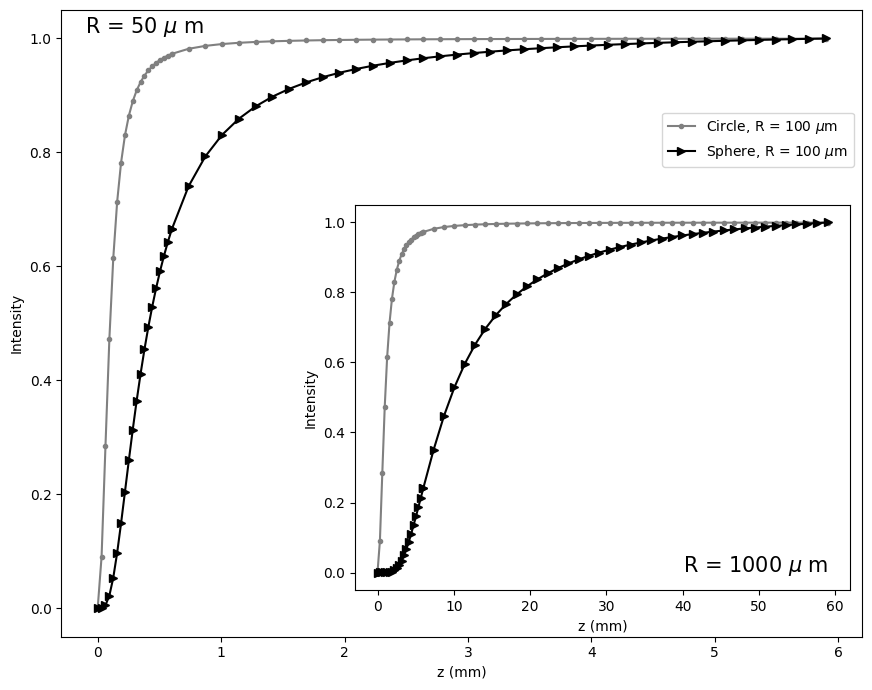

In [18]:

fig = plt.figure(figsize=(9, 7))
gs = gridspec.GridSpec(len(zz_)-1,1, hspace=0.0)  # Adjust `wspace` to control space between columns
# Create subplot in the second column
ax2 = fig.add_subplot(gs[:, 0])

UU_ = np.abs(EE_[1][0] + np.exp(1j*k*zz_[1]))**2 + np.abs(EE_[1][1])**2 + np.abs(EE_[1][2])**2
zi = (zz_[1]-R[1])
ax2.plot(zi/1000, zi**2/(zi**2+R[1]**2), '.-', color='gray',label=f'Circle, R = {R[1]} $\mu$m')
ax2.plot(zi/1000, (UU_)/max(UU_), '>-', color='black', label=f'Sphere, R = {R[1]} $\mu$m')


ax2.annotate(f'R = {R[0]} $\mu$ m',xy=(-0.1,0.98), xytext=(-0.1,1.0098), fontsize = 15)
ax2.legend(loc=(0.75,0.75))
ax2.set_ylabel('Intensity')
#ax2.set_yticks([])
ax2.set_xlabel(r'z (mm)')

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.15, 0.55, 0.55]
ax3 = fig.add_axes([left, bottom, width, height])

UU_ = np.abs(EE_[3][0] + np.exp(1j*k*zz_[3]))**2 + np.abs(EE_[3][1])**2 + np.abs(EE_[3][2])**2
zi = (zz_[3]-R[3])
ax3.plot(zi/1000, zi**2/(zi**2+R[3]**2), '.-', color='gray',label=f'Circle, R = {R[3]} $\mu$m')
ax3.plot(zi/1000, (UU_)/max(UU_), '>-', color='black', label=f'Sphere, R = {R[3]} $\mu$m')

ax3.annotate(f'R = {R[3]} $\mu$ m',xy=(1,0.001), xytext=(40,0.0001), fontsize = 15)
#ax3.legend(loc =(0.57,0.54) )
ax3.set_ylabel('Intensity')
#ax2.set_yticks([])
ax3.set_xlabel(r'z (mm)')

plt.tight_layout()  # Adjusts spacing to prevent overlap
#plt.savefig('Comparar2.pdf',dpi=300)  # Display the plot